In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from typing import Dict, List

# style.use('seaborn-v0_8-whitegrid')
from IPython.display import display

model_names = [
    'Transformer',
    'Resnet18',
    'Resnet50'
    ]

model_batch_sizes: Dict[str, List[int]] = {
    "Transformer": [256, 512, 1024, 2048],
    "Resnet18": [16, 32, 64, 128],
    "Resnet50": [16, 32, 64, 128, 256],
}

# set this to be the same as the one in the experiment
model_idx = 0
batch_idx = 3
mem_ratio = 0.5

model = model_names[model_idx]
batch_size = model_batch_sizes[model][batch_idx]
print(f'model: {model}, batch size {batch_size}')


data_file_pre = f'out/{model}_{batch_size}_pre.csv'

if mem_ratio is None:
    data_file_post = f'out/{model}_{batch_size}_post.csv'
else:
    data_file_post = f'out/{model}_{batch_size}_{mem_ratio}_post.csv'

df_pre = pd.read_csv(data_file_pre)
df_post = pd.read_csv(data_file_post)

# # preprocess here
# df_pre.loc[df_pre['type'] == 'NodeType.GRAD_INTERMEDIATE', 'type'] = 'NodeType.OTHER'
# df_post.loc[df_post['type'] == 'NodeType.GRAD_INTERMEDIATE', 'type'] = 'NodeType.OTHER'

df_pre['type'].unique()

model: Transformer, batch size 2048


array(['NodeType.OTHER', 'NodeType.PARAM', 'NodeType.ACT_DISCARD',
       'NodeType.ACT', 'NodeType.GRAD_INTERMEDIATE', 'NodeType.GRAD'],
      dtype=object)

In [39]:
def get_memory_decomp(df):
    memory_usages : Dict[str, np.array] = dict.fromkeys(['PARAM', 'OTHER', 'GRAD','ACT'])

    name_to_rank = {}
    for _, row in df.iterrows():
        name_to_rank[row['name']] = row['rank']

    for key in memory_usages.keys():
        memory_usages[key] = np.zeros(df.shape[0])

        for _, row in df.iterrows():
            # filter the elements belonging to this type
            if key not in row['type']:
                continue 

            start = row['rank']
            if row['op'] == 'placeholder':
                start = 0
                end = df.shape[0]
            else:
                end = df.shape[0]
                
                if not pd.isna(row['last_use']):
                    end = name_to_rank[row['last_use']]

            memory_usages[key][start:end] += row['size']
    
    memory_usage = np.zeros_like(memory_usages['ACT'])
    for key, val in memory_usages.items():
        memory_usage += val

    return memory_usages, memory_usage

def plot_memory_over_time(df, suffix='pre', breakdown=True):
    name_to_rank = {}
    for _, row in df.iterrows():
        name_to_rank[row['name']] = row['rank']

    display(df.head())
    display(df['type'].value_counts())
    
    # some preprocessing
    df['mem_cuda_GB'] = df.mem_cuda * 1e-9
    df['mem_cuda_pre_GB'] = df.mem_cuda_pre * 1e-9
    df['mem_cuda_peak_GB'] = df.mem_cuda_peak * 1e-9


    op_start = df[df.op == 'call_function']['rank'].min()
    sep_rank = df[df.name == 'sep']['rank'].item()
    sep_back_rank = df[df.name == 'sep_backward']['rank'].item()
    opt_start = df[df.name == '_foreach_lerp_']['rank'].item()

    print('op_start, sep_rank, sep_back_rank, optim_start')
    print(op_start, sep_rank, sep_back_rank, opt_start)

    peak_cuda_rank = df['mem_cuda_GB'].argmax()
    print(f'Peak cuda memory at rank: {peak_cuda_rank}')


    df_grad = df[:opt_start]

    # make sure to give a minimum allocation size
    # DOES NOT CHANGE ANYTHING
    # df['size'] = df['size'].where(df['size'] > 512, 512)

    # compute memory usage here

    memory_breakdown, memory_usage = get_memory_decomp(df)
    
    plt.grid()
    plt.plot(df.mem_cuda_GB, color = 'k', alpha=1.0, label='Memory consumption (cuda)')
    
    if breakdown:
        x = list(range(len(memory_breakdown['ACT'])))
        
        ys = [val/1e9 for _, val in memory_breakdown.items()]
        labels = [key for key, _ in memory_breakdown.items()]
        plt.stackplot(x, ys, alpha=0.4, labels = labels)
    else:
        plt.plot(memory_usage/1e9, color='b', alpha=0.8, label='Predicted Memory')
    
    plt.title(f'Memory consumption - {model} (Batch size: {batch_size})', fontsize=14)
    plt.xlabel('Operations', fontsize = 14)
    plt.ylabel('Memory Consumption (GB)', fontsize = 14)

    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)

    plt.axvline(op_start, color='b', linestyle='--', alpha=0.3, label='Begin of forward pass')
    plt.axvline(sep_rank, color='r', linestyle='--', alpha=0.3, label='End of forward pass')

    plt.legend(fontsize=12)
    plt.savefig(f'figs/memory_prediction_{model}_{batch_size}_{suffix}.png')
    plt.show()


,rank,name,op,target,all_input_nodes,users,size,effective_size,runtime,type,mem_cuda,mem_cuda_pre,mem_cuda_peak,first_forward,last_forward,first_backward,last_backward,last_use
0,0,arg0_1,placeholder,arg0_1,[],{},131072.0,131072.0,0.027680,NodeType.OTHER,42808320,42808320,42808320,NaN,NaN,NaN,NaN,NaN
1,1,arg0_2,placeholder,arg0_2,[],"{embedding_1: None, _foreach_addcdiv: None, co...",16384.0,16384.0,0.018832,NodeType.PARAM,42808320,42808320,42808320,embedding_1,embedding_1,_foreach_addcdiv,copy__1213,copy__1213
2,2,arg0_3,placeholder,arg0_3,[],"{native_layer_norm: None, mul_113: None, _fore...",64.0,64.0,0.016368,NodeType.PARAM,42808320,42808320,42808320,native_layer_norm,native_layer_norm,mul_113,copy__1214,copy__1214
3,3,arg0_4,placeholder,arg0_4,[],"{native_layer_norm: None, _foreach_addcdiv: No...",64.0,64.0,0.016424,NodeType.PARAM,42808320,42808320,42808320,native_layer_norm,native_layer_norm,_foreach_addcdiv,copy__1215,copy__1215
4,4,arg0_5,placeholder,arg0_5,[],"{t: None, _foreach_addcdiv: None, copy__1216: ...",1024.0,1024.0,0.016288,NodeType.PARAM,42808320,42808320,42808320,t,t,_foreach_addcdiv,copy__1216,copy__1216


NodeType.OTHER                3255
NodeType.GRAD_INTERMEDIATE     740
NodeType.ACT                   238
NodeType.ACT_DISCARD           219
NodeType.PARAM                 100
NodeType.GRAD                  100
Name: type, dtype: int64

op_start, sep_rank, sep_back_rank, optim_start
408 861 864 1908
Peak cuda memory at rank: 866


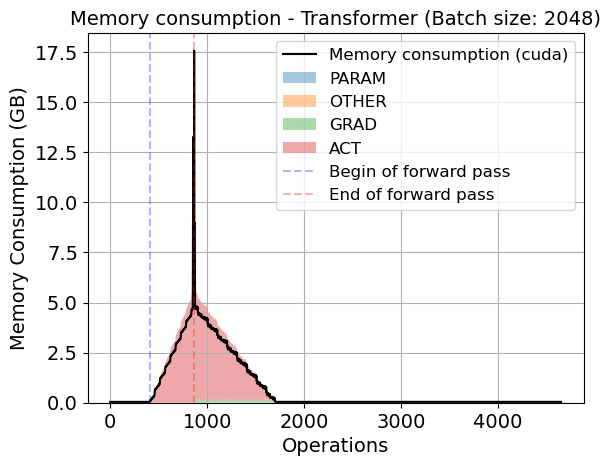

In [40]:
plot_memory_over_time(df_pre)

In [41]:
def get_memory_data(model_idx, ac = False, mem_ratio = None):
    model_name = model_names[model_idx]
    batch_sizes = model_batch_sizes[model_name]

    suffix = 'post' if ac else 'pre'

    data = dict.fromkeys(batch_sizes)

    for b in batch_sizes:
        peak_memories = dict.fromkeys([ 'PARAM', 'OTHER', 'GRAD', 'ACT'])

        data_file = f'out/{model_name}_{b}_{suffix}.csv'
        
        if ac and mem_ratio is not None:
            data_file = f'out/{model_name}_{b}_{mem_ratio}_{suffix}.csv'
            
        df_b = pd.read_csv(data_file)

        usages, total = get_memory_decomp(df_b)
        peak_idx = np.argmax(total)
        print(peak_idx)
        print([(key, usages[key][peak_idx]) for key in usages.keys()])

        peak_memories['ACT'] = usages['ACT'][peak_idx]
        peak_memories['PARAM'] = usages['PARAM'][peak_idx]
        peak_memories['GRAD'] = usages['GRAD'][peak_idx]
        peak_memories['OTHER'] = sum([usages[key][peak_idx] for key in usages.keys() if key not in ['ACT', 'PARAM', 'GRAD']])

        data[b]= peak_memories
    
    return data

def get_runtime_data(model_idx, ac = False, mem_ratio = None):
    model_name = model_names[model_idx]
    batch_sizes = model_batch_sizes[model_name]

    suffix = 'post' if ac else 'pre'

    data = {}
    for b in batch_sizes:
        data_file = f'out/{model_name}_{b}_{suffix}.csv'
        
        if ac and mem_ratio is not None:
            data_file = f'out/{model_name}_{b}_{mem_ratio}_{suffix}.csv'
            
        df_b = pd.read_csv(data_file)

        total_runtime = df_b['runtime'].sum()
        data[b] = total_runtime
    
    return data

def runtime_plot(model_idx, mem_ratio = None):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(8, 4)
    model_name = model_names[model_idx]
    batch_sizes = np.array(model_batch_sizes[model_name])
    
    y_max = 0.0
    for i, ac in enumerate([False, True]):
        
        data = get_runtime_data(model_idx, ac=ac, mem_ratio=mem_ratio)

        ax[i].grid()
        bottom = np.zeros(len(batch_sizes))

        ax[i].set_xscale('log', base=2)
        ax[i].tick_params(axis='both', labelsize=12)
        ax[i].set_xlabel('Batch size (log-scale)', fontsize = 14)
        ax[i].set_ylabel('Runtime (ms)', fontsize = 14)

        modifier = 'w/' if ac else 'w/o'  

        ax[i].set_title(f'Runtime {modifier} AC', fontsize=14)

        widths = 0.2 * batch_sizes
        xs = batch_sizes
        ys = np.array([data[b] for b in batch_sizes])
        y_max = max(y_max, ys.max())
        p = ax[i].bar(xs, ys, widths)

    # set the y-limit
    for i, ac in enumerate([False, True]):
        ax[i].set_ylim(0, y_max* 1.1)


    fig.suptitle(f'Runtime for {model_name} with and without AC by batch size')
    fig.tight_layout()
    plt.savefig(f'figs/{model_name}_{mem_ratio}_runtime.png')
    plt.legend()
    plt.show()
    
def peak_memory_plot(model_idx, mem_ratio = None):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(8, 4)
    model_name = model_names[model_idx]
    batch_sizes = np.array(model_batch_sizes[model_name])
    
    for i, ac in enumerate([False, True]):
        data = get_memory_data(model_idx, ac, mem_ratio)

        ax[i].grid()
        bottom = np.zeros(len(batch_sizes))

        ax[i].set_ylim(0.1, 30)
        ax[i].set_xscale('log', base=2)
        ax[i].tick_params(axis='both', labelsize=12)
        ax[i].set_xlabel('Batch size (log-scale)', fontsize = 14)
        ax[i].set_ylabel('Peak memory (GB)', fontsize = 14)

        modifier = 'w/' if ac else 'w/o'  

        ax[i].set_title(f'Peak memory {modifier} AC', fontsize=14)

        widths = 0.2 * batch_sizes

        for idx, mem_type in enumerate(data[batch_sizes[0]].keys()):
            xs = batch_sizes
            ys = np.array([data[b][mem_type] for b in batch_sizes]) / 1e9
            p = ax[i].bar(xs, ys, widths, label=mem_type, bottom=bottom)
            bottom += ys

    fig.suptitle(f'Peak memory breakdown for {model_name} with and without AC by batch size')
    fig.tight_layout()
    plt.legend()
    plt.savefig(f'figs/{model_name}_{mem_ratio}_peak_memory.png')
    plt.show()

1330
[('PARAM', 102228128.0), ('OTHER', 214303724.0), ('GRAD', 84414368.0), ('ACT', 1313554344.0)]
1296
[('PARAM', 102228128.0), ('OTHER', 223937644.0), ('GRAD', 64581536.0), ('ACT', 2691227560.0)]
1277
[('PARAM', 102228128.0), ('OTHER', 243205484.0), ('GRAD', 85290912.0), ('ACT', 5407965096.0)]
1277
[('PARAM', 102228128.0), ('OTHER', 281741164.0), ('GRAD', 162361248.0), ('ACT', 10815733672.0)]
1277
[('PARAM', 102228128.0), ('OTHER', 358812524.0), ('GRAD', 316501920.0), ('ACT', 21631270824.0)]
1330
[('PARAM', 102228128.0), ('OTHER', 214303724.0), ('GRAD', 84414368.0), ('ACT', 1159413672.0)]
1296
[('PARAM', 102228128.0), ('OTHER', 223937644.0), ('GRAD', 64581536.0), ('ACT', 2357256104.0)]
1277
[('PARAM', 102228128.0), ('OTHER', 243205484.0), ('GRAD', 85290912.0), ('ACT', 4637261736.0)]
1277
[('PARAM', 102228128.0), ('OTHER', 281741164.0), ('GRAD', 162361248.0), ('ACT', 9274326952.0)]
1277
[('PARAM', 102228128.0), ('OTHER', 358812524.0), ('GRAD', 316501920.0), ('ACT', 18959499176.0)]


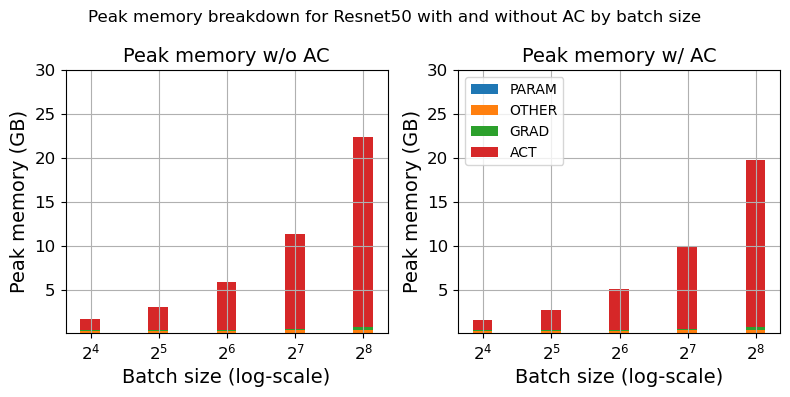

None

1330
[('PARAM', 102228128.0), ('OTHER', 214303724.0), ('GRAD', 84414368.0), ('ACT', 1313554344.0)]
1296
[('PARAM', 102228128.0), ('OTHER', 223937644.0), ('GRAD', 64581536.0), ('ACT', 2691227560.0)]
1277
[('PARAM', 102228128.0), ('OTHER', 243205484.0), ('GRAD', 85290912.0), ('ACT', 5407965096.0)]
1277
[('PARAM', 102228128.0), ('OTHER', 281741164.0), ('GRAD', 162361248.0), ('ACT', 10815733672.0)]
1277
[('PARAM', 102228128.0), ('OTHER', 358812524.0), ('GRAD', 316501920.0), ('ACT', 21631270824.0)]
1986
[('PARAM', 102228128.0), ('OTHER', 214303724.0), ('GRAD', 866170784.0), ('ACT', 218372008.0)]
1342
[('PARAM', 102228128.0), ('OTHER', 223937644.0), ('GRAD', 142217120.0), ('ACT', 1727807400.0)]
1360
[('PARAM', 102228128.0), ('OTHER', 243205484.0), ('GRAD', 257822624.0), ('ACT', 3532537768.0)]
1242
[('PARAM', 102228128.0), ('OTHER', 281741164.0), ('GRAD', 0.0), ('ACT', 7578812328.0)]
1360
[('PARAM', 102228128.0), ('OTHER', 358812524.0), ('GRAD', 874385312.0), ('ACT', 14335229864.0)]


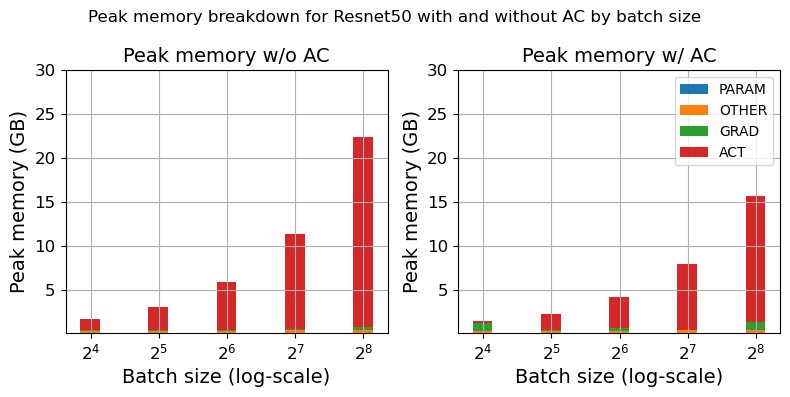

None

1330
[('PARAM', 102228128.0), ('OTHER', 214303724.0), ('GRAD', 84414368.0), ('ACT', 1313554344.0)]
1296
[('PARAM', 102228128.0), ('OTHER', 223937644.0), ('GRAD', 64581536.0), ('ACT', 2691227560.0)]
1277
[('PARAM', 102228128.0), ('OTHER', 243205484.0), ('GRAD', 85290912.0), ('ACT', 5407965096.0)]
1277
[('PARAM', 102228128.0), ('OTHER', 281741164.0), ('GRAD', 162361248.0), ('ACT', 10815733672.0)]
1277
[('PARAM', 102228128.0), ('OTHER', 358812524.0), ('GRAD', 316501920.0), ('ACT', 21631270824.0)]
6373
[('PARAM', 102228128.0), ('OTHER', 623213524.0), ('GRAD', 3198418944.0), ('ACT', 424.0)]
2292
[('PARAM', 102228128.0), ('OTHER', 223937644.0), ('GRAD', 7192660896.0), ('ACT', 102761384.0)]
2209
[('PARAM', 102228128.0), ('OTHER', 243205484.0), ('GRAD', 3851951008.0), ('ACT', 1438659496.0)]
2521
[('PARAM', 102228128.0), ('OTHER', 281741164.0), ('GRAD', 10121033632.0), ('ACT', 1644173224.0)]
1401
[('PARAM', 102228128.0), ('OTHER', 358812524.0), ('GRAD', 1182666656.0), ('ACT', 10404642728.0)]


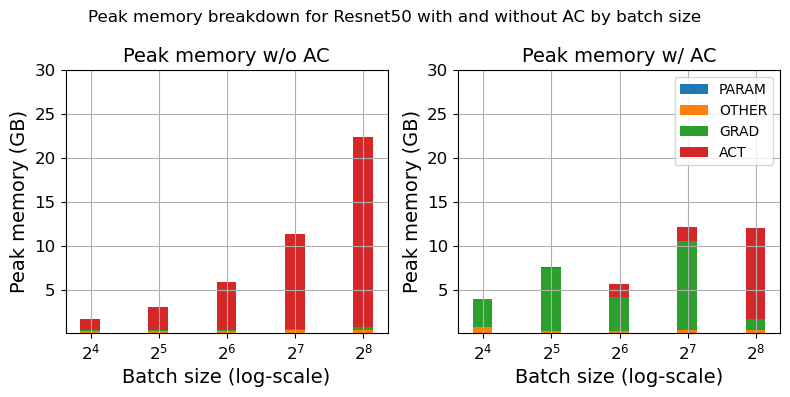

None

865
[('PARAM', 250496.0), ('OTHER', 1943188.0), ('GRAD', 536870912.0), ('ACT', 1218152576.0)]
865
[('PARAM', 250496.0), ('OTHER', 2991764.0), ('GRAD', 1073741824.0), ('ACT', 2436073600.0)]
865
[('PARAM', 250496.0), ('OTHER', 5088916.0), ('GRAD', 2147483648.0), ('ACT', 4871915648.0)]
865
[('PARAM', 250496.0), ('OTHER', 9283220.0), ('GRAD', 4294967296.0), ('ACT', 9743599744.0)]
865
[('PARAM', 250496.0), ('OTHER', 1943188.0), ('GRAD', 536870912.0), ('ACT', 1218152576.0)]
865
[('PARAM', 250496.0), ('OTHER', 2991764.0), ('GRAD', 1073741824.0), ('ACT', 2436073600.0)]
865
[('PARAM', 250496.0), ('OTHER', 5088916.0), ('GRAD', 2147483648.0), ('ACT', 4871915648.0)]
865
[('PARAM', 250496.0), ('OTHER', 9283220.0), ('GRAD', 4294967296.0), ('ACT', 9743599744.0)]


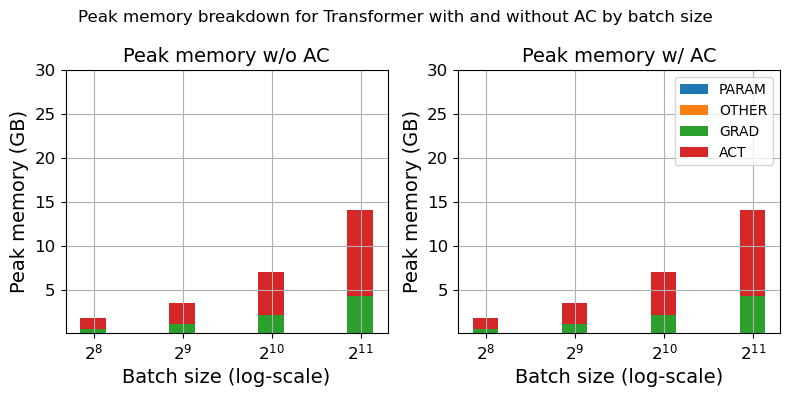

None

865
[('PARAM', 250496.0), ('OTHER', 1943188.0), ('GRAD', 536870912.0), ('ACT', 1218152576.0)]
865
[('PARAM', 250496.0), ('OTHER', 2991764.0), ('GRAD', 1073741824.0), ('ACT', 2436073600.0)]
865
[('PARAM', 250496.0), ('OTHER', 5088916.0), ('GRAD', 2147483648.0), ('ACT', 4871915648.0)]
865
[('PARAM', 250496.0), ('OTHER', 9283220.0), ('GRAD', 4294967296.0), ('ACT', 9743599744.0)]
869
[('PARAM', 250496.0), ('OTHER', 1943188.0), ('GRAD', 1073741824.0), ('ACT', 463177856.0)]
869
[('PARAM', 250496.0), ('OTHER', 2991764.0), ('GRAD', 2147483648.0), ('ACT', 892569728.0)]
865
[('PARAM', 250496.0), ('OTHER', 5088916.0), ('GRAD', 2147483648.0), ('ACT', 3932391552.0)]
865
[('PARAM', 250496.0), ('OTHER', 9283220.0), ('GRAD', 4294967296.0), ('ACT', 7730333824.0)]


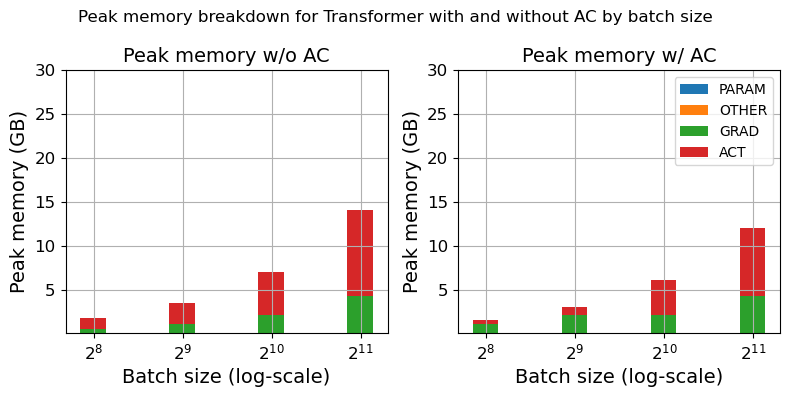

None

865
[('PARAM', 250496.0), ('OTHER', 1943188.0), ('GRAD', 536870912.0), ('ACT', 1218152576.0)]
865
[('PARAM', 250496.0), ('OTHER', 2991764.0), ('GRAD', 1073741824.0), ('ACT', 2436073600.0)]
865
[('PARAM', 250496.0), ('OTHER', 5088916.0), ('GRAD', 2147483648.0), ('ACT', 4871915648.0)]
865
[('PARAM', 250496.0), ('OTHER', 9283220.0), ('GRAD', 4294967296.0), ('ACT', 9743599744.0)]
1219
[('PARAM', 250496.0), ('OTHER', 1943188.0), ('GRAD', 1094717440.0), ('ACT', 77142144.0)]
1290
[('PARAM', 250496.0), ('OTHER', 2991764.0), ('GRAD', 2189430784.0), ('ACT', 70254720.0)]
1230
[('PARAM', 250496.0), ('OTHER', 5088916.0), ('GRAD', 4378857472.0), ('ACT', 291504256.0)]
1212
[('PARAM', 250496.0), ('OTHER', 9283220.0), ('GRAD', 8757710848.0), ('ACT', 683671680.0)]


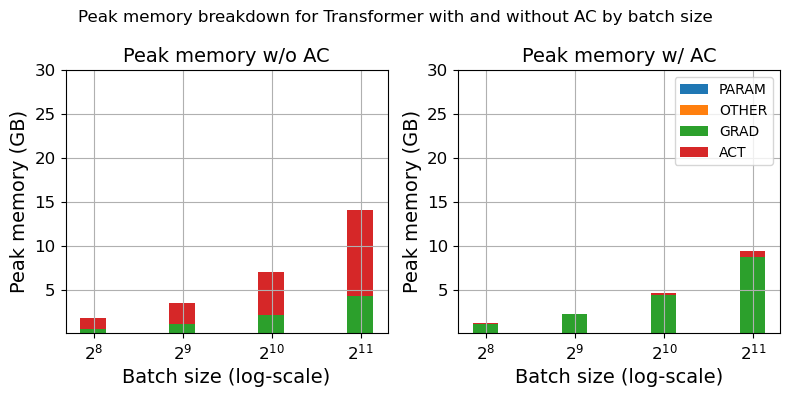

None

In [42]:
display(peak_memory_plot(2, mem_ratio=0.9))
display(peak_memory_plot(2, mem_ratio=0.7))
display(peak_memory_plot(2, mem_ratio=0.5))

display(peak_memory_plot(0, mem_ratio=0.9))
display(peak_memory_plot(0, mem_ratio=0.7))
display(peak_memory_plot(0, mem_ratio=0.5))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


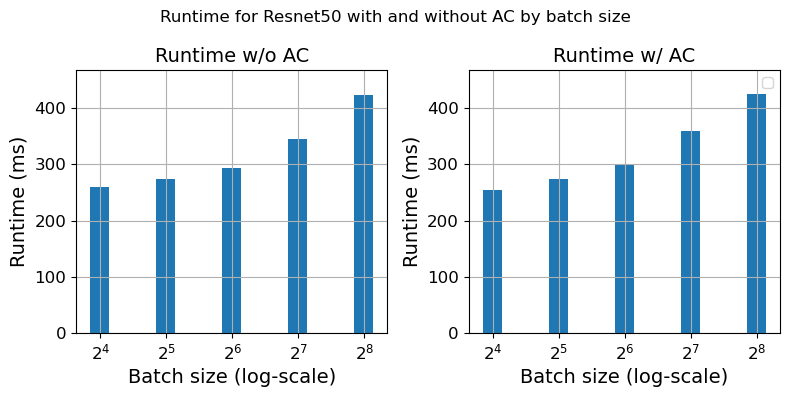

None

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


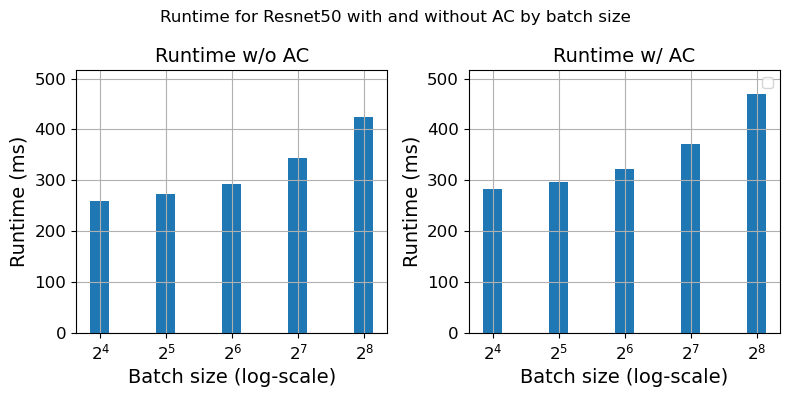

None

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


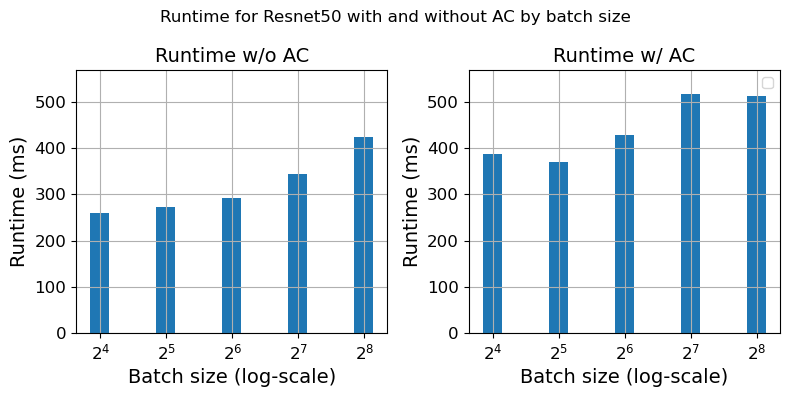

None

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


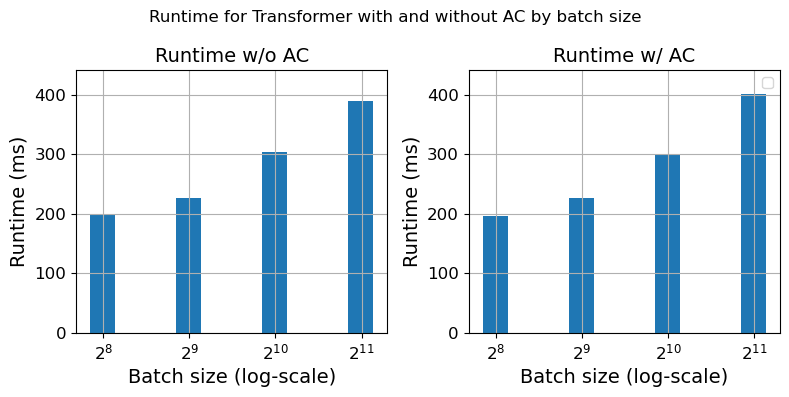

None

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


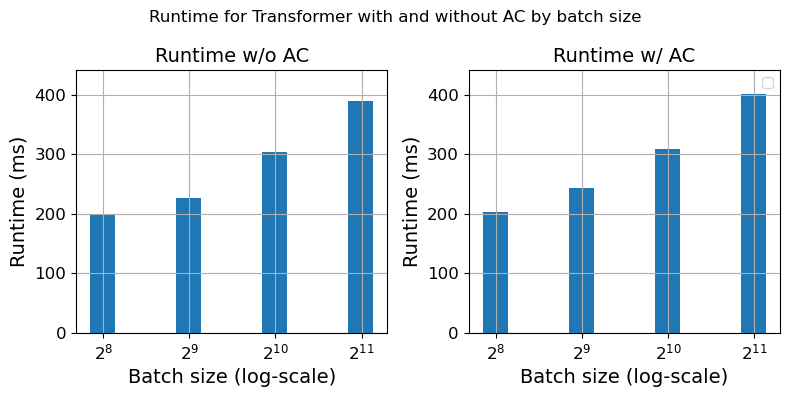

None

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


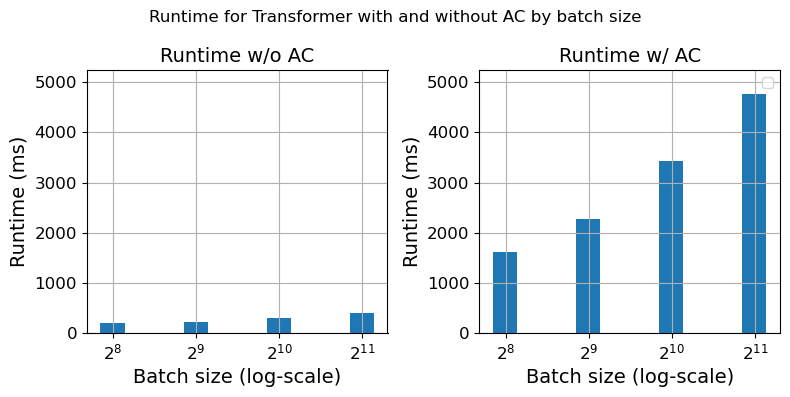

None

In [31]:
display(runtime_plot(2, mem_ratio=0.9))
display(runtime_plot(2, mem_ratio=0.7))
display(runtime_plot(2, mem_ratio=0.5))

display(runtime_plot(0, mem_ratio=0.9))
display(runtime_plot(0, mem_ratio=0.7))
display(runtime_plot(0, mem_ratio=0.5))

1330
[('PARAM', 102228128.0), ('OTHER', 214303724.0), ('GRAD', 84414368.0), ('ACT', 1313553920.0), ('ACT_DISCARD', 424.0)]
1296
[('PARAM', 102228128.0), ('OTHER', 223937644.0), ('GRAD', 64581536.0), ('ACT', 2691227136.0), ('ACT_DISCARD', 424.0)]
1277
[('PARAM', 102228128.0), ('OTHER', 243205484.0), ('GRAD', 85290912.0), ('ACT', 5407964672.0), ('ACT_DISCARD', 424.0)]
1277
[('PARAM', 102228128.0), ('OTHER', 281741164.0), ('GRAD', 162361248.0), ('ACT', 10815733248.0), ('ACT_DISCARD', 424.0)]
1277
[('PARAM', 102228128.0), ('OTHER', 358812524.0), ('GRAD', 316501920.0), ('ACT', 21631270400.0), ('ACT_DISCARD', 424.0)]
1986
[('PARAM', 102228128.0), ('OTHER', 214303724.0), ('GRAD', 866170784.0), ('ACT', 218371584.0), ('ACT_DISCARD', 424.0)]
1342
[('PARAM', 102228128.0), ('OTHER', 223937644.0), ('GRAD', 142217120.0), ('ACT', 1727806976.0), ('ACT_DISCARD', 424.0)]
1360
[('PARAM', 102228128.0), ('OTHER', 243205484.0), ('GRAD', 257822624.0), ('ACT', 3532537344.0), ('ACT_DISCARD', 424.0)]
1242
[('PA

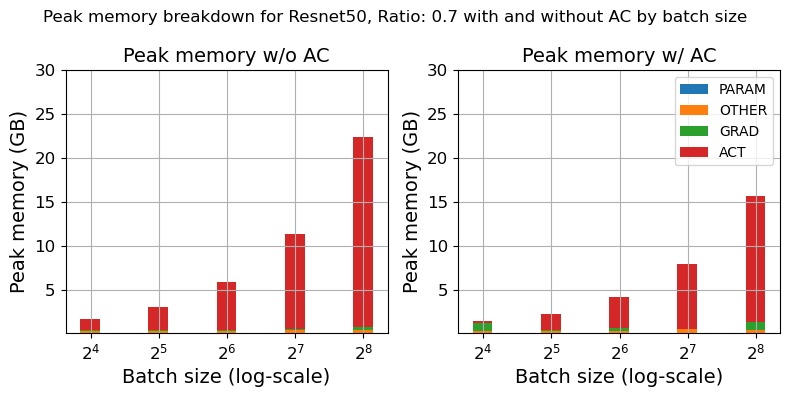

None

865
[('PARAM', 250496.0), ('OTHER', 1943188.0), ('GRAD', 536870912.0), ('ACT', 1218152576.0), ('ACT_DISCARD', 0.0)]
865
[('PARAM', 250496.0), ('OTHER', 2991764.0), ('GRAD', 1073741824.0), ('ACT', 2436073600.0), ('ACT_DISCARD', 0.0)]
865
[('PARAM', 250496.0), ('OTHER', 5088916.0), ('GRAD', 2147483648.0), ('ACT', 4871915648.0), ('ACT_DISCARD', 0.0)]
865
[('PARAM', 250496.0), ('OTHER', 9283220.0), ('GRAD', 4294967296.0), ('ACT', 9743599744.0), ('ACT_DISCARD', 0.0)]
1219
[('PARAM', 250496.0), ('OTHER', 1943188.0), ('GRAD', 1094717440.0), ('ACT', 77142144.0), ('ACT_DISCARD', 0.0)]
1290
[('PARAM', 250496.0), ('OTHER', 2991764.0), ('GRAD', 2189430784.0), ('ACT', 70254720.0), ('ACT_DISCARD', 0.0)]
1230
[('PARAM', 250496.0), ('OTHER', 5088916.0), ('GRAD', 4378857472.0), ('ACT', 291504256.0), ('ACT_DISCARD', 0.0)]
1212
[('PARAM', 250496.0), ('OTHER', 9283220.0), ('GRAD', 8757710848.0), ('ACT', 683671680.0), ('ACT_DISCARD', 0.0)]


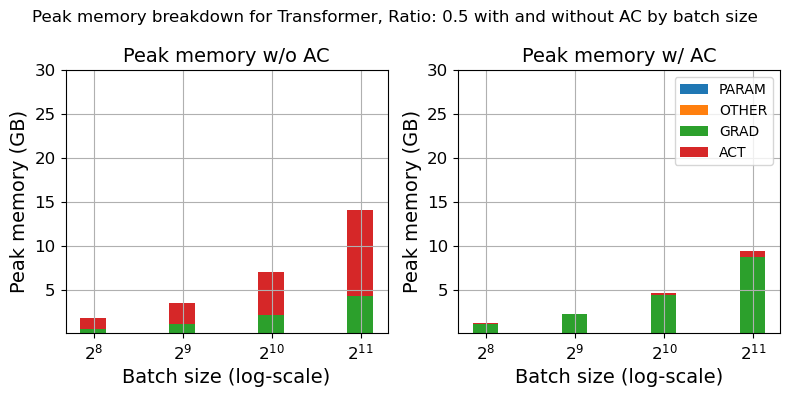

None

In [6]:
# resnet w/o AC peak memory breakdown
display(peak_memory_plot(2, mem_ratio=0.7))
display(peak_memory_plot(0, mem_ratio=0.5))
    

,rank,name,op,target,all_input_nodes,users,size,effective_size,runtime,type,mem_cuda,mem_cuda_pre,mem_cuda_peak,first_forward,last_forward,first_backward,last_backward,last_use
0,0,arg0_1,placeholder,arg0_1,[],{},131072.0,131072.0,0.027680,NodeType.OTHER,42808320,42808320,42808320,NaN,NaN,NaN,NaN,NaN
1,1,arg0_2,placeholder,arg0_2,[],"{embedding_1: None, _foreach_addcdiv: None, co...",16384.0,16384.0,0.018832,NodeType.PARAM,42808320,42808320,42808320,embedding_1,embedding_1,_foreach_addcdiv,copy__1213,copy__1213
2,2,arg0_3,placeholder,arg0_3,[],"{native_layer_norm: None, mul_113: None, _fore...",64.0,64.0,0.016368,NodeType.PARAM,42808320,42808320,42808320,native_layer_norm,native_layer_norm,mul_113,copy__1214,copy__1214
3,3,arg0_4,placeholder,arg0_4,[],"{native_layer_norm: None, _foreach_addcdiv: No...",64.0,64.0,0.016424,NodeType.PARAM,42808320,42808320,42808320,native_layer_norm,native_layer_norm,_foreach_addcdiv,copy__1215,copy__1215
4,4,arg0_5,placeholder,arg0_5,[],"{t: None, _foreach_addcdiv: None, copy__1216: ...",1024.0,1024.0,0.016288,NodeType.PARAM,42808320,42808320,42808320,t,t,_foreach_addcdiv,copy__1216,copy__1216


NodeType.OTHER                3255
NodeType.GRAD_INTERMEDIATE     740
NodeType.ACT                   238
NodeType.ACT_DISCARD           219
NodeType.PARAM                 100
NodeType.GRAD                  100
Name: type, dtype: int64

op_start, sep_rank, sep_back_rank, optim_start
408 861 864 1908
Peak cuda memory at rank: 866


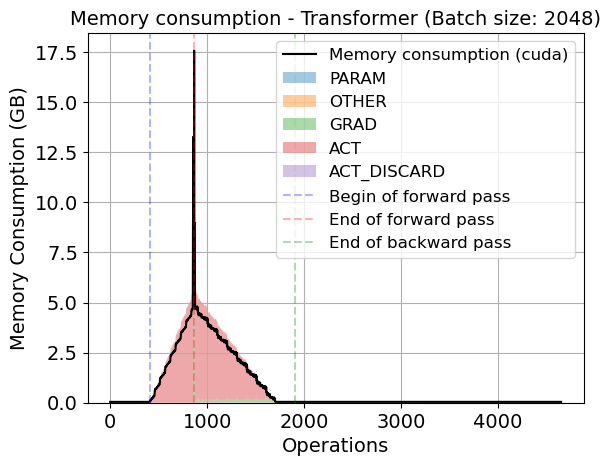

In [8]:
plot_memory_over_time(df_pre, suffix='pre')

,rank,name,op,target,all_input_nodes,users,size,effective_size,runtime,type,mem_cuda,mem_cuda_pre,mem_cuda_peak,first_forward,last_forward,first_backward,last_backward,last_use
0,0,arg0_1,placeholder,arg0_1,[],{},131072.0,131072.0,0.028992,NodeType.OTHER,42808320,42808320,42808320,NaN,NaN,NaN,NaN,NaN
1,1,arg0_2,placeholder,arg0_2,[],"{embedding_1: None, _foreach_addcdiv: None, co...",16384.0,16384.0,0.021392,NodeType.PARAM,42808320,42808320,42808320,embedding_1,embedding_1,embedding_125,copy__1213,copy__1213
2,2,arg0_3,placeholder,arg0_3,[],"{native_layer_norm: None, mul_113: None, _fore...",64.0,64.0,0.017552,NodeType.PARAM,42808320,42808320,42808320,native_layer_norm,native_layer_norm,native_layer_norm_525,copy__1214,copy__1214
3,3,arg0_4,placeholder,arg0_4,[],"{native_layer_norm: None, _foreach_addcdiv: No...",64.0,64.0,0.016456,NodeType.PARAM,42808320,42808320,42808320,native_layer_norm,native_layer_norm,native_layer_norm_525,copy__1215,copy__1215
4,4,arg0_5,placeholder,arg0_5,[],"{t: None, _foreach_addcdiv: None, copy__1216: ...",1024.0,1024.0,0.017984,NodeType.PARAM,42808320,42808320,42808320,t,t,t_1294,copy__1216,copy__1216


NodeType.GRAD_INTERMEDIATE    16592
NodeType.OTHER                 3255
NodeType.ACT_DISCARD            365
NodeType.PARAM                  100
NodeType.GRAD                   100
NodeType.ACT                     92
Name: type, dtype: int64

op_start, sep_rank, sep_back_rank, optim_start
408 861 864 17760
Peak cuda memory at rank: 1169


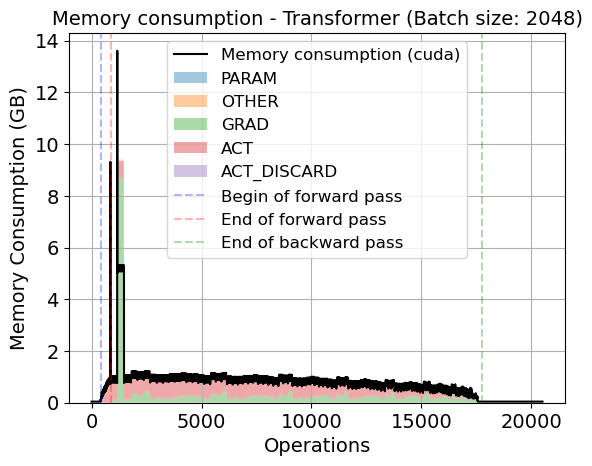

In [9]:
plot_memory_over_time(df_post, suffix='post', breakdown=True)